In [1]:
from pyforestscan.handlers import read_lidar
from pyforestscan.visualize import plot_2d, plot_3d
from pyforestscan.process import filter_hag
from pyforestscan.calculate import assign_voxels, calculate_lad, calculate_lai


In [3]:
file_path = "data/transect2.laz"
geopackage_path = "data/transect2_s1_buffer.gpkg"
dtm_path = "data/transect2_dtm.tif"

In [4]:
arrays = read_lidar(file_path, thin_radius=0.2, hag_dtm=True, dtm=dtm_path, crop_poly=True, poly=geopackage_path)
points = filter_hag(arrays)

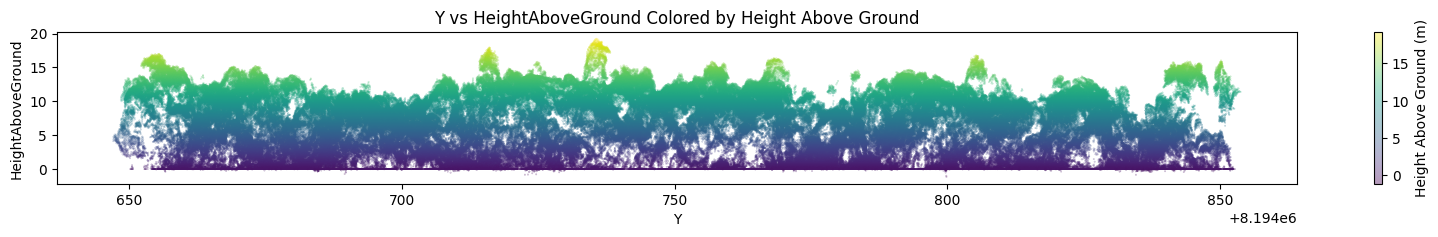

In [7]:
plot_2d(arrays[0], x_dim='Y', y_dim='HeightAboveGround', alpha=0.4, point_size=0.1)

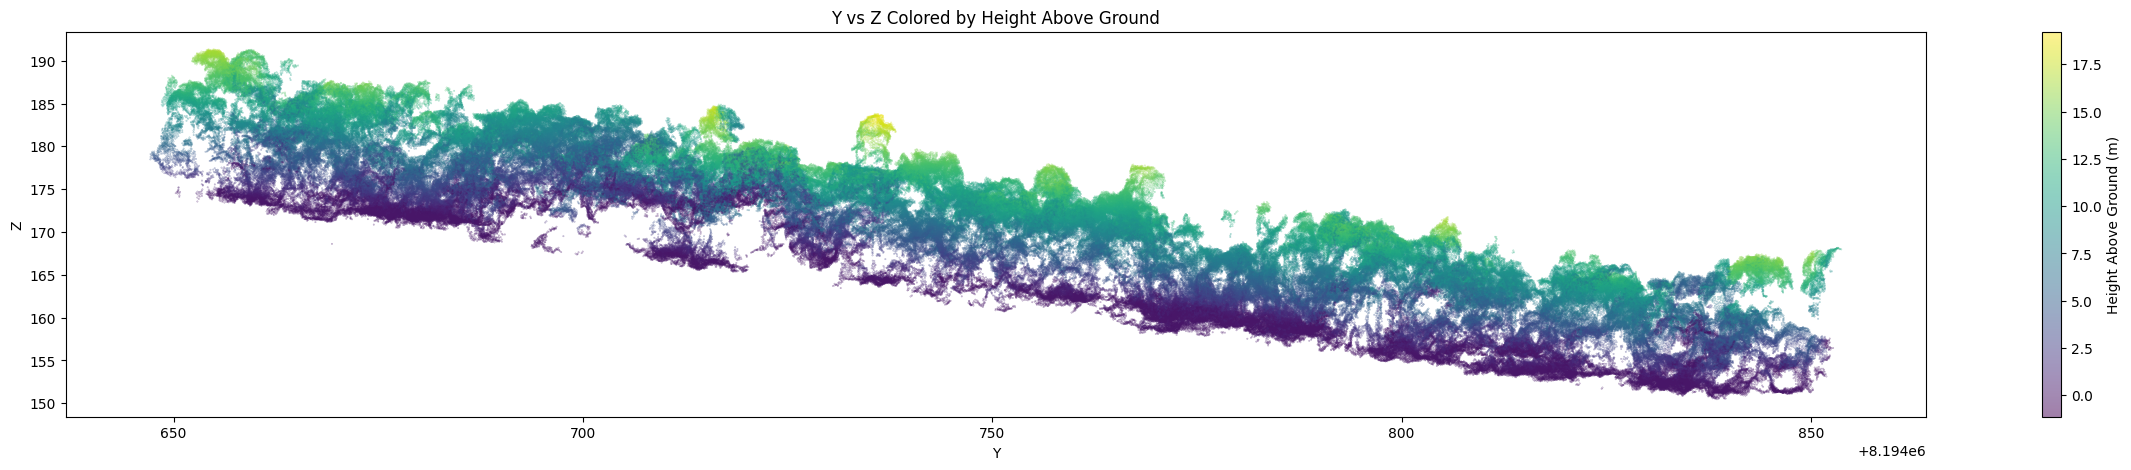

In [5]:
plot_2d(arrays[0], x_dim='Y', y_dim='Z', alpha=0.5, point_size=0.1, fig_size=(30, 5))

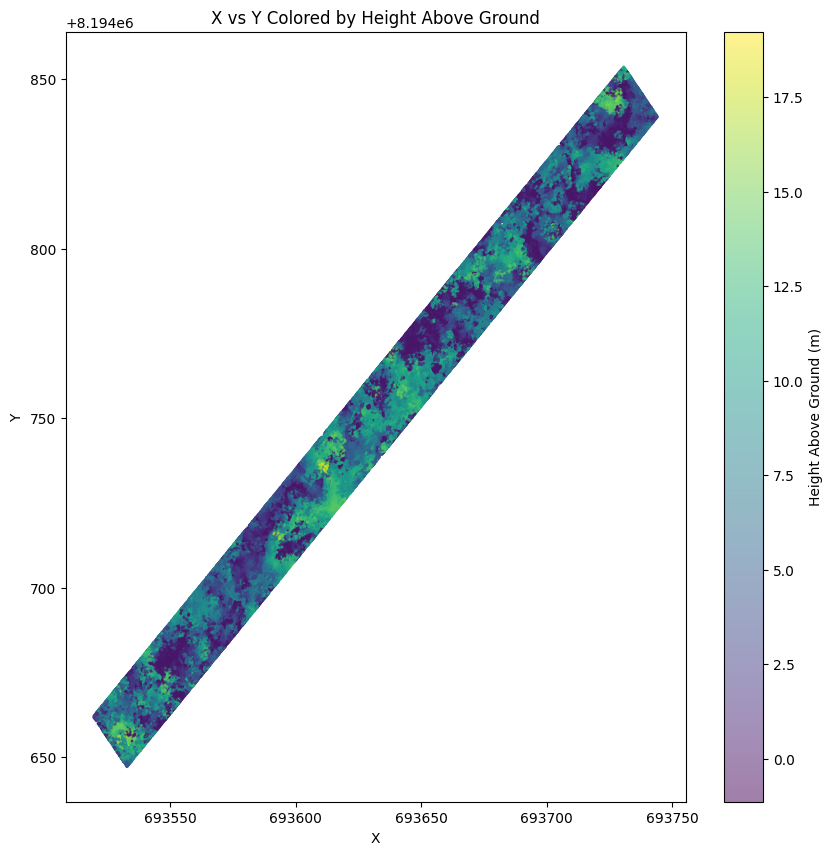

In [6]:
plot_2d(arrays, x_dim='X', y_dim='Y')

In [2]:
file_path = "/media/iosefa/Data/ankarafantsika/drone/ODM/ioda1/odm_georeferencing/odm_georeferenced_model.laz"
geopackage_path = "plot14.gpkg"
dtm_path = "/media/iosefa/Data/ankarafantsika/drone/ODM/ioda1/odm_dem/dtm.tif"

In [3]:
arrays = process_lidar_data(file_path, geopackage_path, dtm_path, radius=0.2)

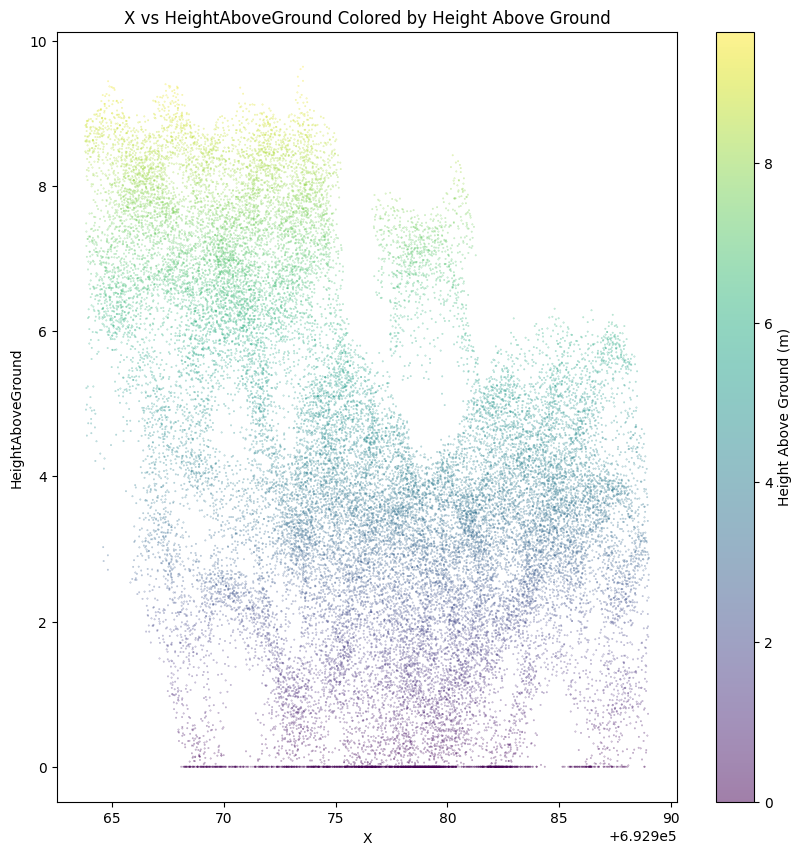

In [4]:
plot_2d(arrays, x_dim='X', y_dim='HeightAboveGround', alpha=0.5, point_size=0.1, fig_size=(10, 10))

In [5]:
write_pdal_pipeline(arrays, 'plot14.las')

In [6]:
import pandas as pd
import numpy as np

In [150]:
def assign_voxels(arr, voxel_resolution, z_resolution):
    laz_df = pd.DataFrame(arr)

    x_bin = np.arange(laz_df['X'].min(), laz_df['X'].max() + voxel_resolution, voxel_resolution)
    y_bin = np.arange(laz_df['Y'].min(), laz_df['Y'].max() + voxel_resolution, voxel_resolution)
    z_bin = np.arange(laz_df['HeightAboveGround'].min(), laz_df['HeightAboveGround'].max() + z_resolution, z_resolution)

    histogram, edges = np.histogramdd(np.vstack((arr['X'], arr['Y'], arr['HeightAboveGround'])).transpose(), bins=(x_bin, y_bin, z_bin))
    
    spatial_extent = {'xmin': arr['X'].min(), 'ymin': arr['Y'].min(), 
                  'xmax': arr['X'].max(), 'ymax': arr['Y'].max()}
    
    return histogram, spatial_extent


def calc_lad(voxel_returns, voxel_height, beer_lambert_constant=None):
    return_accum = np.cumsum(voxel_returns[::-1], axis=2)[::-1]
    shots_in = return_accum
    shots_through = return_accum - voxel_returns

    division_result = np.divide(shots_in, shots_through, out=np.full(shots_in.shape, np.nan), where=~np.isnan(shots_through))

    k = beer_lambert_constant if beer_lambert_constant else 1
    dz = voxel_height

    lad = np.log(division_result) * (1 / (k * dz))

    lad = np.where(np.isinf(lad) | np.isnan(lad), np.nan, lad)

    return lad

def calc_lai(lad):
    return np.nansum(lad, axis=2)

In [151]:
voxels, spatial_extent = assign_voxels(arrays[0], 5, 1)

In [152]:
lad = calc_lad(voxels, voxel_height=1, beer_lambert_constant=None)
lai = calc_lai(lad)
lai

/tmp/ipykernel_3367256/3957081636.py:21: RuntimeWarning: divide by zero encountered in divide
  division_result = np.divide(shots_in, shots_through, out=np.full(shots_in.shape, np.nan), where=~np.isnan(shots_through))
/tmp/ipykernel_3367256/3957081636.py:21: RuntimeWarning: invalid value encountered in divide
  division_result = np.divide(shots_in, shots_through, out=np.full(shots_in.shape, np.nan), where=~np.isnan(shots_through))


array([[1.55059741, 3.22087383, 5.29258669, 3.21157652, 5.7365723 ,
        0.        ],
       [3.07398447, 1.83410702, 2.90591977, 3.2929838 , 2.91495145,
        0.        ],
       [2.13512463, 3.61747054, 1.11272413, 1.72960681, 2.26259135,
        4.04305127],
       [6.85118493, 4.41548827, 1.18060876, 1.13647689, 2.26035233,
        0.        ],
       [5.26009615, 2.14381383, 2.44752504, 3.84392259, 2.45372372,
        0.        ],
       [0.        , 0.        , 2.07944154, 0.        , 0.        ,
        0.        ]])

In [148]:
def create_geotiff(layer, output_file, crs, spatial_extent):
    transform = rasterio.transform.from_bounds(spatial_extent['xmin'], spatial_extent['ymin'], 
                                               spatial_extent['xmax'], spatial_extent['ymax'], 
                                               layer.shape[1], layer.shape[0])
    
    new_dataset = rasterio.open(output_file, 'w', driver='GTiff',
                                height = layer.shape[0], width = layer.shape[1],
                                count=1, dtype=str(layer.dtype),
                                crs=crs,
                                transform=transform)
    
    new_dataset.write(layer, 1)
    new_dataset.close()

create_geotiff(lai, 'lai_5.tif', 'EPSG:32738', spatial_extent)


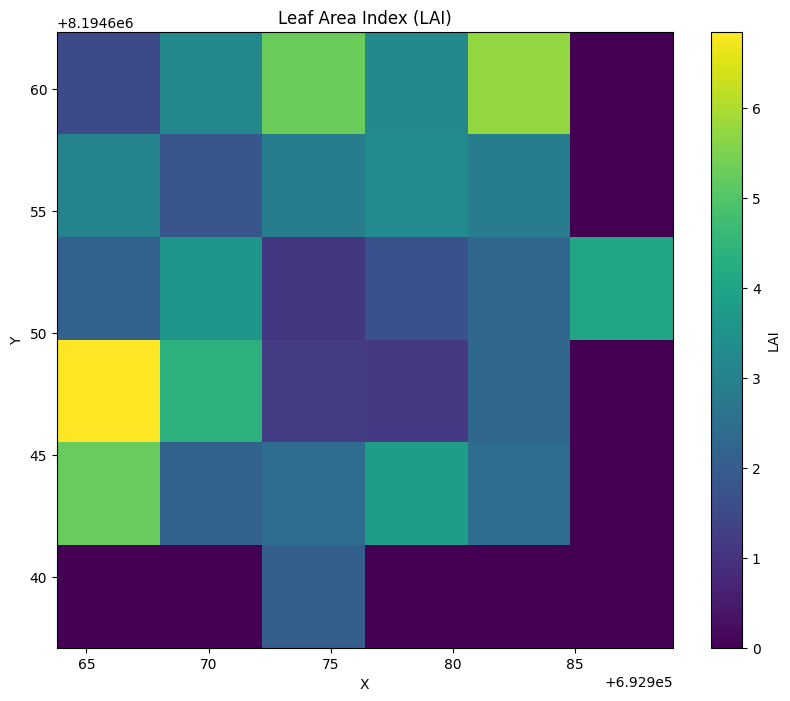

In [149]:
def plot_lai(lai, extent):
    plt.figure(figsize=(10, 8))
    plt.imshow(lai, extent=extent, cmap='viridis')
    plt.colorbar(label='LAI')
    plt.title('Leaf Area Index (LAI)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Calculate the spatial extent for the plot
plot_extent = [spatial_extent['xmin'], spatial_extent['xmax'], spatial_extent['ymin'], spatial_extent['ymax']]

plot_lai(lai, plot_extent)

In [57]:
np.cumsum(voxels[::-1], axis=2)[::-1]

array([[[ 2014,  5122,  9706, 15615, 19476, 21914, 24776, 27818, 29918,
         30045]]])